### Casual Stuff for syntax purpose

In [7]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import Statevector, SparsePauliOp, state_fidelity, concurrence, DensityMatrix, partial_trace
from qiskit_algorithms import *
from qiskit_ibm_runtime import *

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Or save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='usc/phys550/phys550', token='0d6866ec4cd8e33433ae1c1e7f33875963ad78fcc2f6711eb982e57fb480756eb42fe86c4549e9858a4387c414b780b22351daeaeb156e2fa32292434552aca1', overwrite=True)
# Load saved credentials
service = QiskitRuntimeService()

In [23]:
service.backends()

[<IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_cusco')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_nazca')>]

In [24]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_cusco'

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as Sampler

 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=12)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(result[0].get_counts())

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as sampler

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")
 
sampler = Sampler(backend)
job = sampler.run([qc])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

### Totterization

In [36]:
c=[]

In [37]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [38]:
from math import pi

H = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

In [39]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("10")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

In [40]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

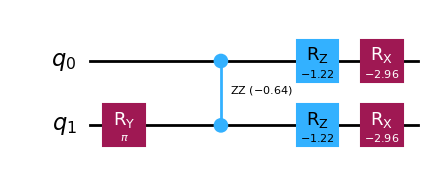

In [41]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

In [42]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))


In [43]:
c.append(concurrence(statevector))
print(c) 

[nan]


/Users/rishwithimmaraju/QuantumPython/.venv/lib/python3.12/site-packages/qiskit/quantum_info/states/measures.py:213: RuntimeWarning: invalid value encountered in sqrt
  return float(np.sqrt(2 * (1 - np.real(purity(rho)))))


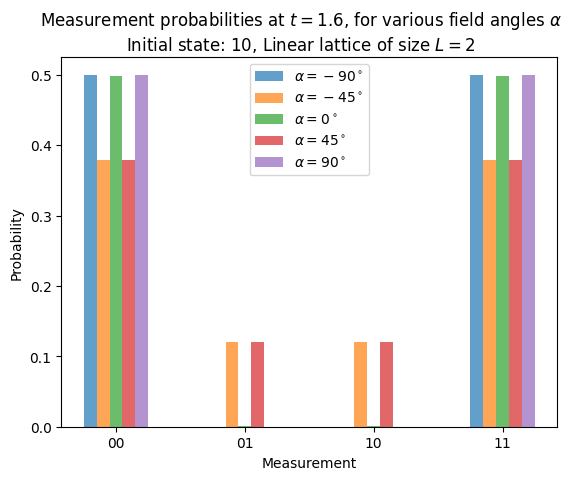

In [34]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.1
# We prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector([1/sqrt(2), 0, 0, +1/sqrt(2)])
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    c.append(concurrence(statevector))
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

In [35]:
print(c)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
c=[]

In [30]:
"""MULTIPLE TIMES TOTTER"""

from math import pi, sqrt

from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

#for final_time in t:
H = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=pi / 8)

final_time = 1.6
# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector([1/sqrt(2), 0, 0, +1/sqrt(2)])

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

trotter = TrotterQRTE()
result = trotter.evolve(problem)

result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

statevector = Statevector(result.evolved_state)
print(statevector)

c.append(concurrence(statevector))
print(c) 

Statevector([-0.43310531+0.55719655j, -0.0138973 +0.04193646j,
             -0.0138973 +0.04193646j, -0.01463669-0.7055735j ],
            dims=(2, 2))
[1.0]


### IDENTITY Gate IBM Run

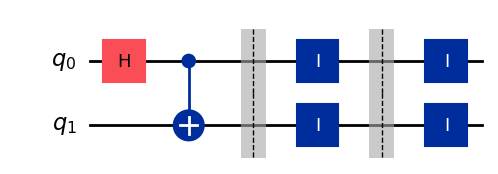

In [3]:
#circuit with Identity Gates
iqc = QuantumCircuit(2)

iqc.h(0)
iqc.cx(0,1)

iqc.barrier()
iqc.id([0,1])
iqc.barrier()
iqc.id([0,1])

iqc.draw(output='mpl')

In [6]:
s = StateVector.from_instruction(iqc)

NameError: name 'StateVector' is not defined

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as sampler

 
service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

results = sampler(backend, options={'shots':}).run(mmqc).result()
print(results)

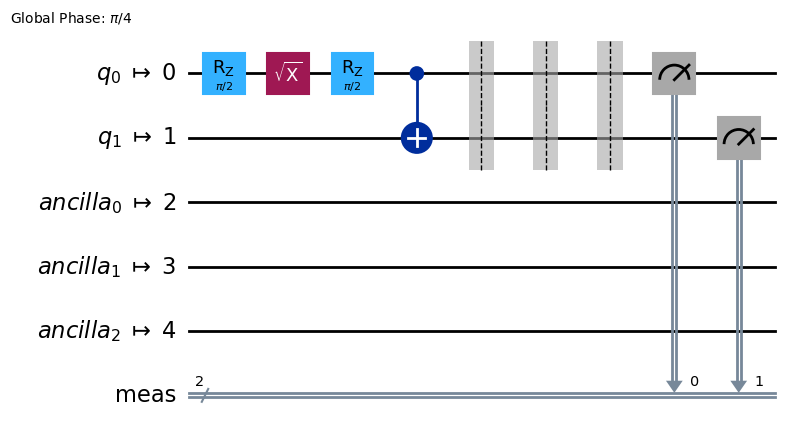

In [16]:
"""RUN IT USING FAKE PROVIDERS"""

from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
 
# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=5)
 
# Create a simple circuit
iqc = QuantumCircuit(2)
iqc.h(0)
iqc.cx(0,1)

iqc.barrier()
iqc.id([0,1])
iqc.barrier()
iqc.id([0,1])
iqc.measure_all()
 
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(iqc, backend)
transpiled_circuit.draw('mpl')
 


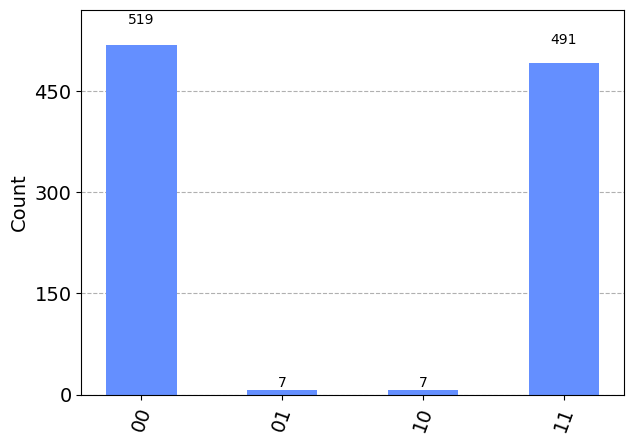

In [11]:
# Run the transpiled circuit using the simulated backend
fake_job = backend.run(transpiled_circuit)
fake_counts = job.result().get_counts()
plot_histogram(counts)

In [15]:
print(job.result())

Result(backend_name='aer_simulator', backend_version='0.14.0.1', qobj_id='', job_id='eb146ee6-c204-4cd9-adae-a0c27745c726', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 7, '0x2': 7, '0x0': 519, '0x3': 491}), header=QobjExperimentHeader(creg_sizes=[['meas', 2]], global_phase=0.7853981633974483, memory_slots=2, n_qubits=5, name='circuit-860', qreg_sizes=[['q', 5]], metadata={}), status=DONE, seed_simulator=2662235547, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000119375, 'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.015099208, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 8192, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'density_matrix', 'required_memory_mb': 1, 'fusion': {'enabled': T

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
backend = service.get_backend("simulator_statevector")

job = backend.run(iqc)
result =job.result()
counts = result.get_counts()
print(counts)

runtime_job._start_websocket_client:WARNING:2024-05-03 12:33:56,498: An error occurred while streaming results from the server for job coqjo4r501i0h3epv650:
Traceback (most recent call last):
  File "/Users/rishwithimmaraju/QuantumPython/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/runtime_job.py", line 549, in _start_websocket_client
    self._ws_client.job_results()
  File "/Users/rishwithimmaraju/QuantumPython/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Users/rishwithimmaraju/QuantumPython/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/Users/rishwithimmaraju/

{'11': 1982, '00': 2018}


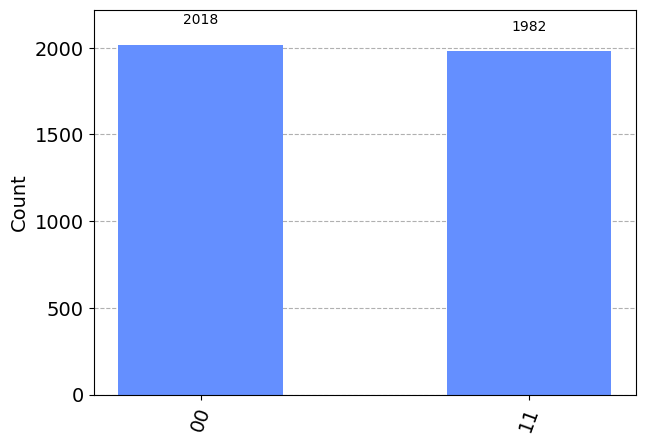

In [19]:
plot_histogram(counts)

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as Sampler

 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=12)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(iqc)
 
sampler = Sampler(backend)
job = sampler.run([isa_circuit], s)
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(result[0].get_counts())

### Our Hamiltonian on IBM systems Run

In [ ]:
from qiskit import *
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, RuntimeOptions
import numpy as np
import matplotlib.pyplot as plt


# Initialize the runtime service
service = QiskitRuntimeService()

# Prepare the initial Bell state |Ψ⟩ = (|01⟩ + |10⟩)/√2
circuit = QuantumCircuit(2)
circuit.x(1)  # Prepare |10⟩
circuit.h(0)  # Apply Hadamard to the first qubit
circuit.cx(0, 1)  # Apply CNOT to create entanglement

# Hamiltonian Parameters
omega0 = 1.0  # Energy level splitting
kappa = 0.1   # Coupling strength between qubits

# Define Pauli operators as SparsePauliOp for tensor operations
Z = SparsePauliOp.from_list([('Z', 1)])
X = SparsePauliOp.from_list([('X', 1)])
Y = SparsePauliOp.from_list([('Y', 1)])
I = SparsePauliOp.from_list([('I', 1)])

# Construct the Hamiltonian using tensor products
H0 = omega0 / 2 * (Z.tensor(I) + I.tensor(Z))
HI = kappa * ((X.tensor(X)) - (Y.tensor(Y)))
H = H0 + HI

# Define time points for simulation
time_points = np.linspace(0, 10, 100)

# Initialize the Sampler
backend = service.backend("ibmq_qasm_simulator")
sampler = Sampler(backend)

# Define options for running the Sampler
options = {backend= 'ibmq_qasm_simulator', shots=100}

# Run the simulation
results = []
for t in time_points:
    job = service.run(
        sampler,
        inputs={
            'circuits': circuit,
            'observable': H,
            'parameter_values': [[t]]
        },
        options=options
    )
    result = job.result()
    # Calculate concurrence for the evolved state
    concurrence_value = concurrence(Statevector(result))  # Ensure you define concurrence computation
    results.append(concurrence_value)

# Plotting the concurrence over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, results, label='Concurrence')
plt.xlabel('Time')
plt.ylabel('Concurrence')
plt.title('Time Evolution of Concurrence')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
import numpy as np
import matplotlib.pyplot as plt

# Initialize the runtime service
service = QiskitRuntimeService()

# Choose the backend
backend = service.backend("ibmq_qasm_simulator")

# Prepare the initial Bell state |Ψ⟩ = (|01⟩ + |10⟩)/√2 and add measurement
circuit = QuantumCircuit(2, 2)  # Add 2 classical bits for measurements
circuit.x(1)  # Prepare |10⟩
circuit.h(0)  # Apply Hadamard to the first qubit
circuit.cx(0, 1)  # Apply CNOT to create entanglement
circuit.measure([0, 1], [0, 1])  # Measure the qubits

# Hamiltonian Parameters
omega0 = 1.0  # Energy level splitting
kappa = 0.1   # Coupling strength between qubits

# Define Pauli operators as SparsePauliOp for tensor operations
Z = SparsePauliOp.from_list([('Z', 1)])
X = SparsePauliOp.from_list([('X', 1)])
Y = SparsePauliOp.from_list([('Y', 1)])
I = SparsePauliOp.from_list([('I', 1)])

# Construct the Hamiltonian using tensor products
H0 = omega0 / 2 * (Z.tensor(I) + I.tensor(Z))
HI = kappa * ((X.tensor(X)) - (Y.tensor(Y)))
H = H0 + HI

# Initialize the Sampler
sampler = Sampler(backend=backend)

# Define options for running the Sampler
options = Options(optimization_level=3)

# Execute the sampler job
job = sampler.run(circuits=circuit, observable=H, shots=1024, options=options)
result = job.result()

# Processing the results
counts = result.get_counts()

# Print counts
print("Measurement Counts:", counts)

# Placeholder for analysis; implement as necessary
# You might want to calculate certain metrics or perform further analysis based on 'counts'


### Rishwi Hand written Python Script for 

In [45]:
"""MY MAIN CODE"""







"""Defining our Bell state circuit"""

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)

"""Getting density matrix from it"""

density_matrix = DensityMatrix.from_instruction(qc)
print(density_matrix)
density_matrix_op = Operator(density_matrix)

"""Get the Hamiltonian"""

from qiskit.quantum_info import SparsePauliOp, Pauli, Operator

# Coefficients
h0 = 1
hx = 1
hy = 1
hz = 1

# Define Hamiltonian for each qubit separately and combine them
H1 = SparsePauliOp(['I', 'X', 'Y', 'Z'], [h0, hx, hy, hz])
H2 = SparsePauliOp(['I', 'X', 'Y', 'Z'], [h0, hx, hy, hz])

# Tensor product to form a two-qubit Hamiltonian
opera = H1.tensor(H2)  # Apply H1 on both qubits

# Convert to Operator if needed
H = Operator(opera)

# Print the Hamiltonian
print("Two-qubit Hamiltonian H:")
print(H)


"""Get the Lindblad Operators"""

# Define Pauli X and Y matrices
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)

# Construct X + iY
X_plus_iY = X + 1j * Y
X_minus_iY = X - 1j * Y

# Create amplitude damping operators from the matrix
l1 = Operator(X_plus_iY)
l2 = Operator(X_minus_iY)


opera1 = l1.tensor(l1)  # Apply H1 on both qubits
opera2 = l2.tensor(l2)

# Convert to Operator if needed
new_l1 = Operator(opera1)
new_l2 = Operator(opera2)

# Print the 4x4 lindblads
print("Operator for X + iY:")
print(new_l1)
print("Operator for X - iY:")
print(new_l2)

# Commutator
ham = H @ density_matrix_op - density_matrix_op @ H

# Anti-commutator
anticomm = new_l2 @ new_l1 @ density_matrix_op + density_matrix_op @ new_l2 @ new_l1

# Dissipator
dissipator = new_l1 @ density_matrix_op @ new_l2 - 0.5 * anticomm

# Print results
print("Commutator:")
print(ham.data)

print("Dissipator:")
print(dissipator.data)

gamma = 0.5

"""OUR FINAL TIME EVOLUTION DENSITY MATRIX"""
rowdot = -1j* ham + 0.5 * dissipator
print(rowdot)

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))
Two-qubit Hamiltonian H:
Operator([[4.+0.j, 2.-2.j, 2.-2.j, 0.-2.j],
          [2.+2.j, 0.+0.j, 2.+0.j, 0.+0.j],
          [2.+2.j, 2.+0.j, 0.+0.j, 0.+0.j],
          [0.+2.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Operator for X + iY:
Operator([[0.+0.j, 0.+0.j, 0.+0.j, 4.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Operator for X - iY:
Operator([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [4.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Commutator:
[[ 0.-

In [ ]:
matrix_elements = [
    [ 0.5,  0,  0, 0.5],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [0.5,  0,  0, 0.5]
]

# Create the DensityMatrix object
dd = DensityMatrix(matrix_elements)

# Check if it is a valid density matrix
print("Is density matrix valid? ", dd.is_valid())

# Calculate concurrence if valid
if dd.is_valid():
    c = concurrence(dd)
    print("Concurrence: ", c)
else:
    print("Invalid density matrix provided.")

### Solver IBM or HOQST